## Streaming larger-than-memory datasets

With the streaming engine, Polars processes the query in multiple batches rather than all at once.

In [1]:
import polars as pl

In [2]:
csv_file = "data/nyc_trip_data_1k.csv"

In [3]:
pl.scan_csv(
    csv_file,
    try_parse_dates=True
).group_by(
    "passenger_count"
).agg(
    pl.col(pl.Float64).mean()
).collect()

passenger_count,trip_distance,fare_amount,tip_amount
f64,f64,f64,f64
3.0,3.627692,13.320513,2.311795
6.0,3.765882,13.147059,2.728824
5.0,1.465882,7.529412,2.08
1.0,3.533347,13.695565,2.545914
4.0,3.73,13.958333,1.824167
2.0,3.351935,13.677419,2.589677
0.0,1.56875,8.25,1.5225


With streaming engine

In [4]:
pl.scan_csv(
    csv_file,
    try_parse_dates=True
).group_by(
    "passenger_count"
).agg(
    pl.col(pl.Float64).mean()
).collect(engine="streaming")

passenger_count,trip_distance,fare_amount,tip_amount
f64,f64,f64,f64
1.0,3.533347,13.695565,2.545914
0.0,1.56875,8.25,1.5225
4.0,3.73,13.958333,1.824167
3.0,3.627692,13.320513,2.311795
6.0,3.765882,13.147059,2.728824
5.0,1.465882,7.529412,2.08
2.0,3.351935,13.677419,2.589677


### Tips for working with the streaming engine

It's not that all queries are supported with streaming engine.

Following this process when processing larger-than-memory datasets:

- start off with a simple query
- check query plan works in streaming mode with `explain`
- add additional logic to the query plan
- check the updated query plan works in streaming mode
- continue adding logic and confirming that the query plan still works in streaming mode

### Profiling

We can profile a query when we use streaming. 

Sadly this is currently less useful than the non-streaming profile as the streaming part of the query plan is gathered together into a single block.

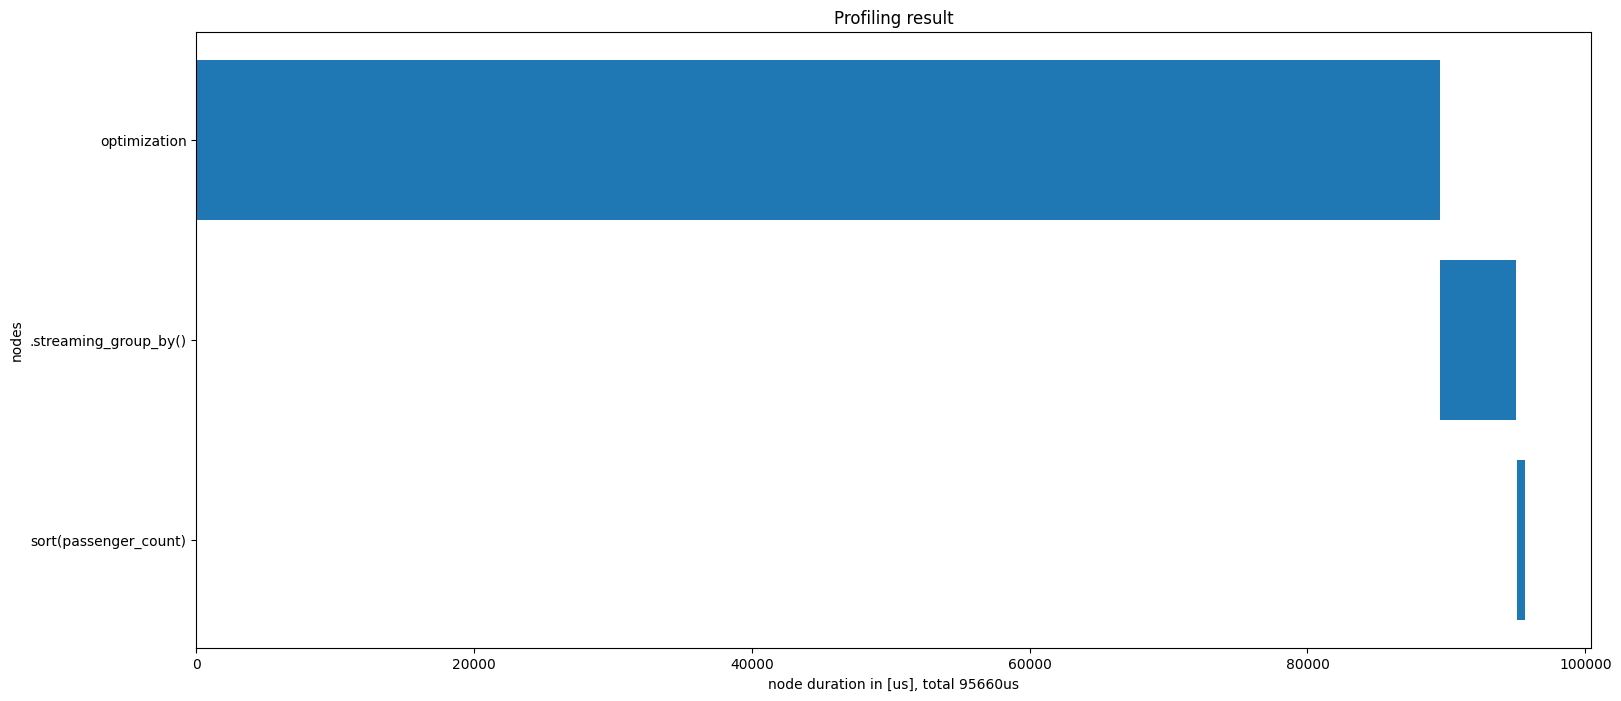

In [16]:
groupDf, profileDf = (
    pl.scan_csv(csv_file)
    .group_by("passenger_count")
    .agg(
        pl.col("trip_distance").mean()
    )
    .sort("passenger_count")
    .profile(engine="streaming",show_plot=True)
)

Groupdf contains the result of query.

In [15]:
groupDf

passenger_count,trip_distance
f64,f64
0.0,1.56875
1.0,3.533347
2.0,3.351935
3.0,3.627692
4.0,3.73
5.0,1.465882
6.0,3.765882


Profiledf have the information about executing query.

In [17]:
profileDf

node,start,end
str,u64,u64
"""optimization""",0,89539
""".streaming_group_by()""",89539,95019
"""sort(passenger_count)""",95052,95660


## GPU engine
Polars has added support for partial processing of queries on an `NVIDIA` GPU.

In [ ]:
print(
    pl.scan_csv(csv_file,try_parse_dates = True)
    .select(
        pl.col("pickup").shift(1)
    )
    .collect(engine="gpu")
)

The GPU engine is still in its early days and so only a subset of operations are supported.